# Country Health Indicators Test

This notebook tests the download and loading of the Country Health Indicators dataset from Kaggle.

In [10]:
# Install required packages
%pip install kagglehub pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [11]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

# Download the dataset to current directory
print("Downloading Country Health Indicators dataset...")
cache_path = kagglehub.dataset_download("nxpnsv/country-health-indicators")

# Copy to current folder
current_dir = os.getcwd()
local_data_dir = current_dir
# local_data_dir = os.path.join(current_dir, "data")
os.makedirs(local_data_dir, exist_ok=True)

# Copy files from cache to local directory
for file in os.listdir(cache_path):
    src = os.path.join(cache_path, file)
    dst = os.path.join(local_data_dir, file)
    shutil.copy2(src, dst)
    print(f"Copied {file} to local data folder")

path = local_data_dir
print(f"Dataset available locally at: {path}")

Copied country_health_indicators_v3.csv to local data folder
Dataset available locally at: /home/tamim/ai4ph/data/country_health_indicators


In [12]:
# Check dataset size
total_size = 0
files = os.listdir(path)
for file in files:
    file_path = os.path.join(path, file)
    size = os.path.getsize(file_path)
    total_size += size
    print(f"- {file}: {size/1024:.1f} KB")

print(f"\nTotal dataset size: {total_size/(1024*1024):.2f} MB")

- README.md: 1.0 KB
- country_health_indicators_v3.csv: 89.2 KB
- dataset_download.ipynb: 2098.1 KB

Total dataset size: 2.14 MB


In [13]:
# Load and explore the data
csv_files = [f for f in files if f.endswith('.csv')]
if csv_files:
    df = pd.read_csv(os.path.join(path, csv_files[0]))
    
    print(f"Dataset shape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nData types:\n{df.dtypes}")
    print(f"\nFirst 5 rows:\n{df.head()}")
    
    # Check for country information
    country_cols = [col for col in df.columns if 'country' in col.lower()]
    if country_cols:
        print(f"\nCountries in dataset: {df[country_cols[0]].nunique()}")
        print(f"Sample countries: {list(df[country_cols[0]].unique()[:10])}")
    
    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\nMissing values:\n{missing[missing > 0].head(10)}")
    else:
        print("\n✅ No missing values found")
    
    # Basic statistics
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) > 0:
        print(f"\nBasic statistics for numeric columns:\n{df[numeric_cols[:5]].describe()}")

Dataset shape: (180, 70)

Columns: ['Country_Region', 'first_1ConfirmedCases', 'first_1Fatalities', 'first_10ConfirmedCases', 'first_50ConfirmedCases', 'first_100ConfirmedCases', 'cases_growth', 'death_growth', 'Cardiovascular diseases (%)', 'Cancers (%)', 'Diabetes, blood, & endocrine diseases (%)', 'Respiratory diseases (%)', 'Liver disease (%)', 'Diarrhea & common infectious diseases (%)', 'Musculoskeletal disorders (%)', 'HIV/AIDS and tuberculosis (%)', 'Malaria & neglected tropical diseases (%)', 'Nutritional deficiencies (%)', 'pneumonia-death-rates', 'Share of deaths from smoking (%)', 'alcoholic_beverages', 'animal_fats', 'animal_products', 'aquatic_products,_other', 'cereals_-_excluding_beer', 'eggs', 'fish,_seafood', 'fruits_-_excluding_wine', 'meat', 'milk_-_excluding_butter', 'miscellaneous', 'offals', 'oilcrops', 'pulses', 'spices', 'starchy_roots', 'stimulants', 'sugar_&_sweeteners', 'treenuts', 'vegetable_oils', 'vegetables', 'vegetal_products', 'hospital_beds_per10k', '

Health indicators found: ['death_growth', 'Cardiovascular diseases (%)', 'Diabetes, blood, & endocrine diseases (%)', 'Respiratory diseases (%)', 'Liver disease (%)', 'Diarrhea & common infectious diseases (%)', 'Malaria & neglected tropical diseases (%)', 'pneumonia-death-rates', 'Share of deaths from smoking (%)', 'population']


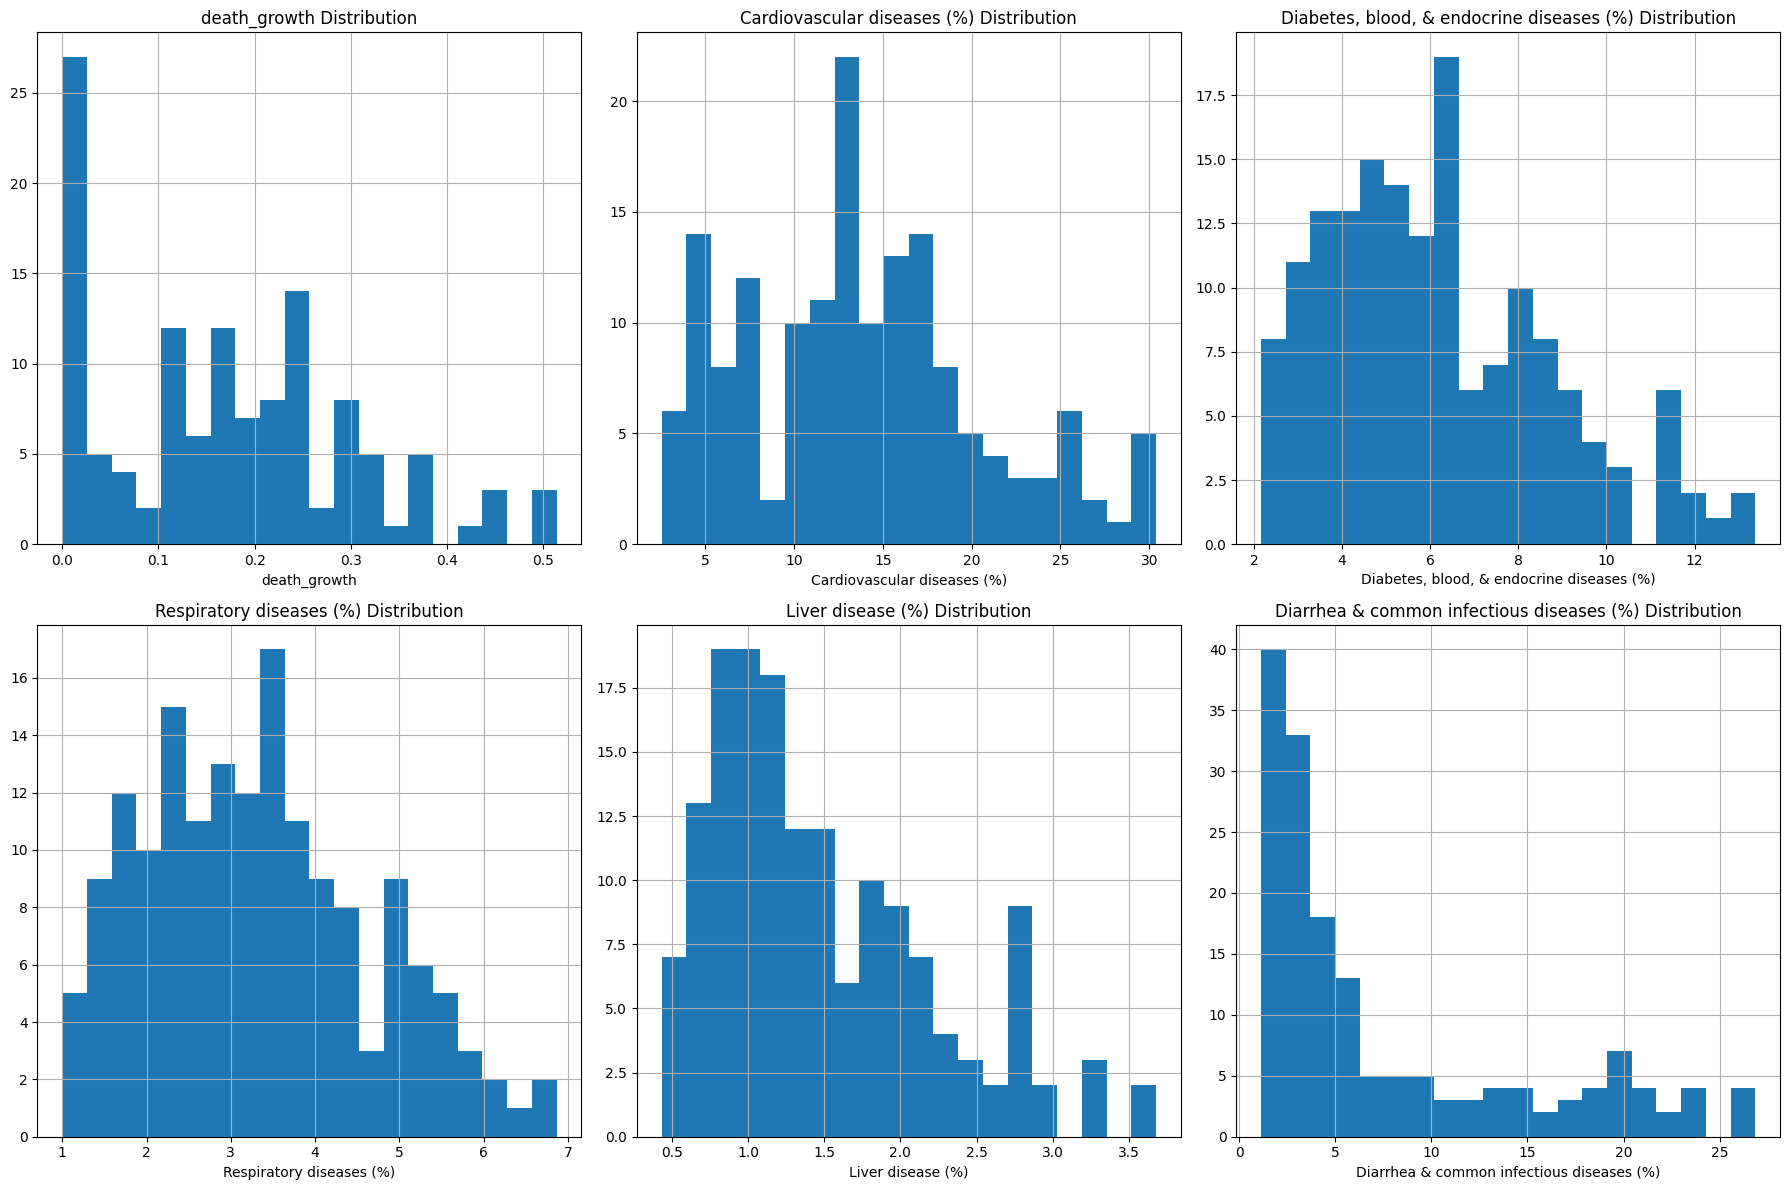

In [14]:
# Create global health visualizations
if csv_files and len(df) > 0:
    # Identify key health indicators
    health_indicators = [col for col in df.columns if any(keyword in col.lower() 
                        for keyword in ['death', 'mortality', 'life', 'health', 'disease', 
                                      'infection', 'rate', 'index', 'gdp', 'population'])]
    
    print(f"Health indicators found: {health_indicators[:10]}")
    
    if len(health_indicators) > 0:
        # Plot distribution of key indicators
        n_plots = min(6, len(health_indicators))
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()
        
        for i, indicator in enumerate(health_indicators[:n_plots]):
            if df[indicator].dtype in ['int64', 'float64']:
                # Remove outliers for better visualization
                data = df[indicator].dropna()
                if len(data) > 0:
                    Q1 = data.quantile(0.25)
                    Q3 = data.quantile(0.75)
                    IQR = Q3 - Q1
                    filtered_data = data[(data >= Q1 - 1.5*IQR) & (data <= Q3 + 1.5*IQR)]
                    
                    filtered_data.hist(bins=20, ax=axes[i])
                    axes[i].set_title(f'{indicator} Distribution')
                    axes[i].set_xlabel(indicator)
            else:
                # For categorical data
                top_values = df[indicator].value_counts().head(10)
                top_values.plot(kind='bar', ax=axes[i])
                axes[i].set_title(f'Top 10 {indicator}')
                axes[i].tick_params(axis='x', rotation=45)
        
        # Hide unused subplots
        for j in range(n_plots, len(axes)):
            axes[j].axis('off')
        
        plt.tight_layout()
        plt.show()


Regional analysis using 'Country_Region':
Country_Region
Afghanistan           1
Albania               1
Algeria               1
Andorra               1
Angola                1
                     ..
Venezuela             1
Vietnam               1
West Bank and Gaza    1
Zambia                1
Zimbabwe              1
Name: count, Length: 180, dtype: int64


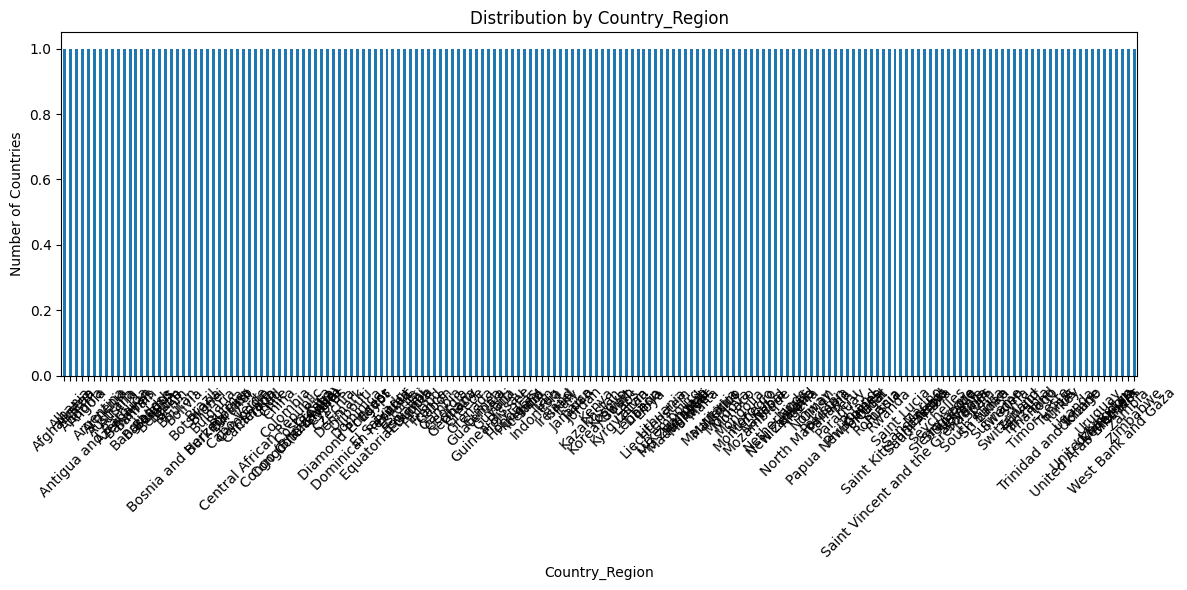

In [15]:
# Regional/Country analysis
if csv_files and len(df) > 0:
    # Look for regional or income grouping columns
    region_cols = [col for col in df.columns if any(keyword in col.lower() 
                  for keyword in ['region', 'continent', 'income', 'group', 'classification'])]
    
    country_cols = [col for col in df.columns if 'country' in col.lower()]
    
    if region_cols and len(region_cols) > 0:
        region_col = region_cols[0]
        print(f"\nRegional analysis using '{region_col}':")
        print(df[region_col].value_counts())
        
        # Plot regional distribution
        plt.figure(figsize=(12, 6))
        df[region_col].value_counts().plot(kind='bar')
        plt.title(f'Distribution by {region_col}')
        plt.xlabel(region_col)
        plt.ylabel('Number of Countries')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    elif country_cols:
        country_col = country_cols[0]
        print(f"\nCountry analysis:")
        print(f"Total countries: {df[country_col].nunique()}")
        print(f"Sample countries: {list(df[country_col].unique()[:15])}")

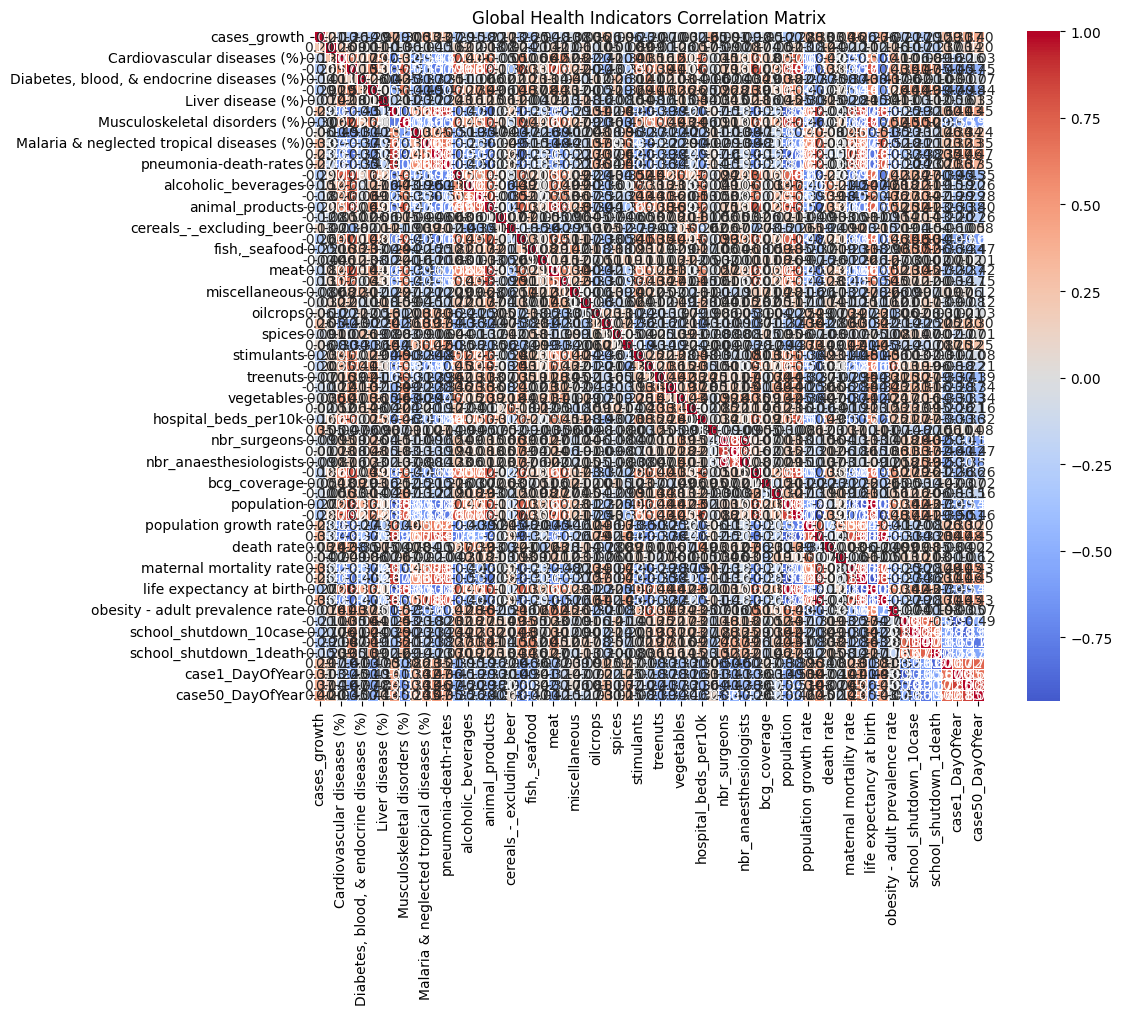


Strongest correlations (|r| > 0.5):
population <-> life expectancy at birth: 1.000
birth rate <-> total fertility rate: 0.980
nbr_surgeons <-> nbr_anaesthesiologists: 0.970
infant mortality rate <-> life expectancy at birth: -0.933
population <-> infant mortality rate: -0.933
median age <-> birth rate: -0.929
school_shutdown_1case <-> case1_DayOfYear: -0.926
Cancers (%) <-> median age: 0.920
Diarrhea & common infectious diseases (%) <-> pneumonia-death-rates: 0.898
Diarrhea & common infectious diseases (%) <-> Nutritional deficiencies (%): 0.892


In [16]:
# Correlation analysis of health indicators
if csv_files and len(df) > 0:
    # Select numeric health indicators
    numeric_health = df.select_dtypes(include=['int64', 'float64']).columns
    
    if len(numeric_health) > 1:
        # Calculate correlation matrix
        health_corr = df[numeric_health].corr()
        
        # Plot correlation heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(health_corr, annot=True, cmap='coolwarm', center=0, 
                    fmt='.2f', square=True, linewidths=0.5)
        plt.title('Global Health Indicators Correlation Matrix')
        plt.tight_layout()
        plt.show()
        
        # Find strongest correlations
        corr_pairs = []
        for i in range(len(health_corr.columns)):
            for j in range(i+1, len(health_corr.columns)):
                corr_val = health_corr.iloc[i, j]
                if abs(corr_val) > 0.5:  # Strong correlations
                    corr_pairs.append((health_corr.columns[i], health_corr.columns[j], corr_val))
        
        if corr_pairs:
            print(f"\nStrongest correlations (|r| > 0.5):")
            for var1, var2, corr in sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
                print(f"{var1} <-> {var2}: {corr:.3f}")

In [17]:
# Top/Bottom performing countries analysis
if csv_files and len(df) > 0:
    country_cols = [col for col in df.columns if 'country' in col.lower()]
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    if country_cols and len(numeric_cols) > 0:
        country_col = country_cols[0]
        
        # Find a key health indicator (prefer life expectancy, death rate, etc.)
        key_indicators = [col for col in numeric_cols if any(keyword in col.lower() 
                         for keyword in ['life', 'death', 'mortality', 'health'])]
        
        if key_indicators:
            indicator = key_indicators[0]
            print(f"\nTop/Bottom countries by {indicator}:")
            
            # Remove missing values and sort
            country_data = df[[country_col, indicator]].dropna()
            
            if len(country_data) > 0:
                # Determine if higher values are better or worse
                is_positive_indicator = any(keyword in indicator.lower() 
                                          for keyword in ['life', 'health', 'index'])
                
                if is_positive_indicator:
                    sorted_data = country_data.sort_values(indicator, ascending=False)
                    print(f"\nTop 10 countries (highest {indicator}):")
                else:
                    sorted_data = country_data.sort_values(indicator, ascending=True)
                    print(f"\nTop 10 countries (lowest {indicator}):")
                
                print(sorted_data.head(10).to_string(index=False))
                
                if not is_positive_indicator:
                    print(f"\nBottom 10 countries (highest {indicator}):")
                    print(sorted_data.tail(10).to_string(index=False))
                else:
                    print(f"\nBottom 10 countries (lowest {indicator}):")
                    print(sorted_data.tail(10).to_string(index=False))


Top/Bottom countries by death_growth:

Top 10 countries (lowest death_growth):
Country_Region  death_growth
        Angola           0.0
       Bahrain           0.0
       Bahamas           0.0
 Cote d'Ivoire           0.0
    Cabo Verde           0.0
         Burma           0.0
        Brunei           0.0
      Botswana           0.0
    Costa Rica           0.0
     Guatemala           0.0

Bottom 10 countries (highest death_growth):
Country_Region  death_growth
         Niger      0.444444
        Russia      0.445942
       Uruguay      0.500000
   El Salvador      0.500000
       Armenia      0.513889
       Estonia      0.630556
      Honduras      0.693651
       Bolivia      0.952381
       Belarus      1.000000
        Serbia      1.731319


In [18]:
print("✅ Dataset download and analysis completed successfully!")
print("\nDataset Summary:")
print(f"- Location: {path}")
print(f"- Size: {total_size/(1024*1024):.2f} MB (Small & manageable!)")
if csv_files:
    print(f"- Records: {df.shape[0]:,}")
    print(f"- Health indicators: {df.shape[1]}")
    if country_cols:
        print(f"- Countries: {df[country_cols[0]].nunique()}")
print("- Use case: Global health analysis, country comparisons, public health surveillance")
print("- Perfect for: Module 4 (Data Visualization), Module 8 (Surveillance), Module 7 (Public Health Modeling)")

✅ Dataset download and analysis completed successfully!

Dataset Summary:
- Location: /home/tamim/ai4ph/data/country_health_indicators
- Size: 2.14 MB (Small & manageable!)
- Records: 180
- Health indicators: 70
- Countries: 180
- Use case: Global health analysis, country comparisons, public health surveillance
- Perfect for: Module 4 (Data Visualization), Module 8 (Surveillance), Module 7 (Public Health Modeling)
